### Tracking Covid Positive Test Results
Given data recorded by Johns Hopkins at https://github.com/CSSEGISandData/COVID-19/ showing the progression of Covid-19 as I wanted to see the data.
<br><br>
First, importing libraries, and then hiding my data import to obscure local directories. The basic strategy in "covid_support" is to open and combine the many csv files of state tests and combine it into one dataframe. state_info provides populations for normalization (this file is included in the repo).

In [1]:
import pandas as pd
import matplotlib
matplotlib.rc('font',size=8)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

%matplotlib inline

In [2]:
# I use the Johns Hopkins Covid dataset for most of my data
# https://github.com/CSSEGISandData/COVID-19/
# Here I'm hiding my import and cleaning of the data since it also reveals my local directories
# covid_support is an ignored file on this repo
# covid_support compiles the daily files from JH data and edits/cleans
from covid_support import combine, cols, states, state_info
today = pd.datetime.today().strftime('%Y-%m-%d')
latest_data = combine.index.max().strftime('%Y-%m-%d')
print("Dashboard updated:\t{} \nLatest Data:\t\t{}".format(today,latest_data))

Dashboard updated:	2021-04-09 
Latest Data:		2021-04-08


#### New Cases Per Day, Normalized
For a selection of states, look at the normalized new cases per day by calculating the difference of the reported cumulative summary. This is averaged over 7 days to account for noise in reporting. <br><br>
I use this to get a broad overview for trends of infections and relative coparison between some states that I find interesting. 

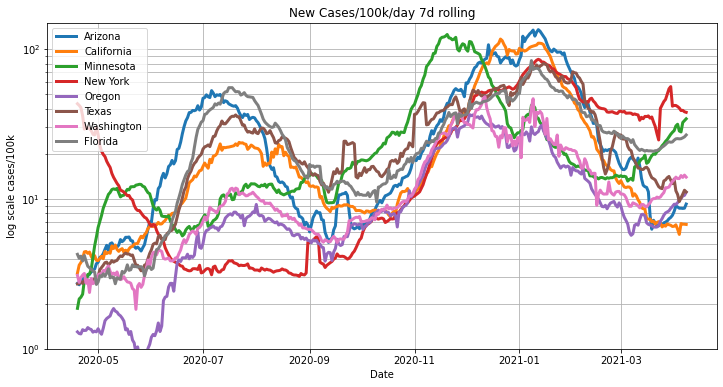

In [3]:
# Select AZ, CA, NY, OR,TX WA, FL
state_info = state_info.iloc[[0,1,8,9,12,14,15,17]]
# New Cases Per Capita
plt.figure(figsize=(12,6))
for i,r in state_info.iterrows():
    new_cases_per_pop = combine['Confirmed',r['State']].diff().rolling(7).mean()/(r['Pop']/1e5)
    plt.plot(combine.index, new_cases_per_pop,linewidth=3, label=r['State'])
plt.title('New Cases/100k/day 7d rolling')
plt.yscale('log')
plt.ylabel('log scale cases/100k')
plt.xlabel('Date')
plt.ylim(1e0,15e1)
plt.legend(loc=2)
plt.grid(which='both')

#### New cases - county-level data
What about specific counties of interest? I look at a few that I am interested in to look at trends in those areas. I was surprised to find Houston (Harris Co.) doing better than a suburban Bay Area county (Solano). Portland (Multnomah Co.) was consistently better than any of the others.

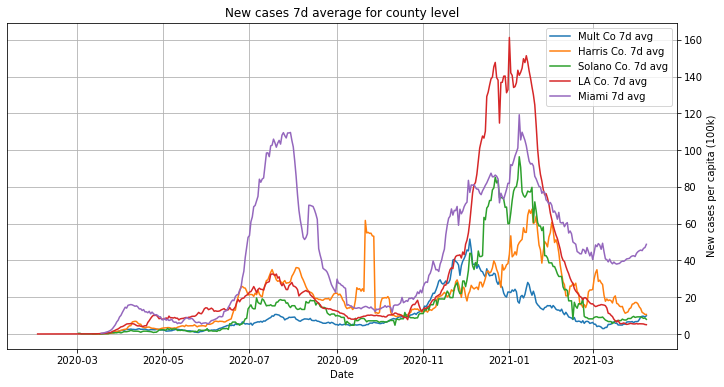

In [4]:
county_data = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df = pd.read_csv(county_data, parse_dates=[0])

mult_pop = 812855   # 2019 pop
har_pop = 4.713e6
sol_pop = 447643
la_pop = 10.04e6
mi_pop = 2.717e6

mult = df[df['county']=="Multnomah"]
mult.index = mult.date
mult['new_cases'] = mult['cases'].diff()
mult['smooth'] = mult['new_cases'].rolling(7).mean()
har = df[(df['county']=="Harris") & (df['state']=="Texas")]
har.index = har.date
har['new_cases'] = har['cases'].diff()
har['smooth'] = har['new_cases'].rolling(7).mean()
sol = df[df['county']=="Solano"]
sol.index = sol.date
sol['new_cases'] = sol['cases'].diff()
sol['smooth'] = sol['new_cases'].rolling(7).mean()
la = df[df['county']=="Los Angeles"]
la.index = la.date
la['new_cases'] = la['cases'].diff()
la['smooth'] = la['new_cases'].rolling(7).mean()
mi = df[df['county']=="Miami-Dade"]
mi.index = mi.date
mi['new_cases'] = mi['cases'].diff()
mi['smooth'] = mi['new_cases'].rolling(7).mean()

# Cases per capita on one plot
plt.figure(figsize=(12,6))
plt.plot(mult.index, mult.smooth*1e5/mult_pop, label='Mult Co 7d avg')
plt.plot(har.index, har.smooth*1e5/har_pop, label='Harris Co. 7d avg')
plt.plot(sol.index, sol.smooth*1e5/sol_pop, label='Solano Co. 7d avg')
plt.plot(la.index, la.smooth*1e5/la_pop, label='LA Co. 7d avg')
plt.plot(mi.index, mi.smooth*1e5/mi_pop, label='Miami 7d avg')
#plt.plot(ri.index, ri.smooth*1e5/ri_pop, label='Prov Co. 7d avg')
plt.xlabel('Date')
plt.ylabel('New cases per capita (100k)')
plt.title('New cases 7d average for county level')
plt.grid(which='both')
plt.legend()
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

#### Risks By Age Group
The Oregon Health Authority reports the number of hospitalizations and deaths per age group. The below is taken from the March 3rd, 2021 report. For example, a 35-year-old who contracts covid has a 2.3% chance of being admitted to the hospital and a 0.1% chance of dying.<br><br>
<img src="OHA_Covid_Ages.PNG">


#### Putting Death Numbers In Context
Is covid worse than the flu? How does it compare to other causes of death? <br><br>
It seemed obvious to me that deaths were much worse than the flu, but this plot can put it into perspective. CDC reported death rates were averaged over a whole year and compared. <br><br>
Note that the comparison rates are averaged over a whole year, so Covid may not eclipse heart disease overall.
<br><br>
Note that the CDC flu deaths were taken from the worst year within the last decade, so it can easily be said that Covid has caused many more deaths than the worst flu season recently.
<br><br>
Covid deaths remained well above car deaths for a majority of the time, so discussions on risk acceptance comparing to driving are not comparable (one can also look at reported mortality for age group, and for 30's the 0.1% death rate [Oregon] is still above mortality risk for driving.

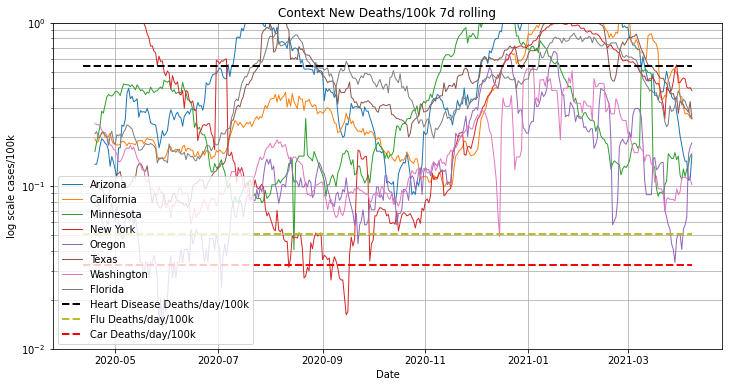

In [5]:
heart_disease = 647457/328.2e6*100000/365   # 197 per 100k people die of heart disease per year
car_deaths = 12/365 # .03 fatality per 100k per year from nhtsa in 2016
flu_deaths = 61000/328.2e6*100000/365  # Estimate for 2018 flu season from CDC, highest deaths in recent records

plt.figure(figsize=(12,6))
for i,r in state_info.iterrows():
    new_deaths_per_pop = combine['Deaths',r['State']].diff().rolling(7).mean()/(r['Pop']/1e5)
    plt.plot(combine.index, new_deaths_per_pop,linewidth=1, label=r['State'])
plt.plot((new_deaths_per_pop.index[0],new_deaths_per_pop.index[-1]),(heart_disease,heart_disease),'--',linewidth=2,c='k',label='Heart Disease Deaths/day/100k')
plt.plot((new_deaths_per_pop.index[0],new_deaths_per_pop.index[-1]),(flu_deaths,flu_deaths),'--',linewidth=2,label='Flu Deaths/day/100k')
plt.plot((new_deaths_per_pop.index[0],new_deaths_per_pop.index[-1]),(car_deaths,car_deaths),'--',linewidth=2,c='r',label='Car Deaths/day/100k')
plt.title('Context New Deaths/100k 7d rolling')
plt.yscale('log')
plt.ylabel('log scale cases/100k')
plt.xlabel('Date')
plt.ylim(1e-2,1e0)
plt.legend(loc=3)
plt.grid(which='both')

A previous pubulication suggested that positive tests underreported cases by 7.7 times, however I am not sure I can fairly use this number that came from early months in the pandemic.
But tests are surely under-representing the positive cases.
NPR reporting on 2/5/21 references a pre-publication paper that suggests current tests are under-representing real new cases by about 4 times (https://www.npr.org/2021/02/05/964358098/researchers-new-model-predicts-number-of-people-currently-contagious-with-covid-)


In [6]:
from IPython.display import display
tot_stats = pd.DataFrame(columns=['TotPerc','CurrentPercent','CurrentPercentLikely'])

for i,r in state_info.iterrows():
    tot = combine['Confirmed',r['State']][-1]/(r['Pop'])
    current = combine['Confirmed',r['State']].diff().rolling(18).sum()[-1]/(r['Pop'])
    #cur_more = current * 7.7   # one paper estiamted 7.7 times undercounted cases (but we're going to only report positive tests here)
    cur_more = current * 4 # recent NPR reporting on Columbia paper
    tot = "{0:.2f}%".format(tot * 100)
    current = "{0:.2f}%".format(current * 100)
    cur_more = "{0:.2f}%".format(cur_more * 100)
    tot_stats.loc[r['State']] = [tot,current,cur_more]
    
print("Total and current percent of pop that has tested positive for covid:")
display(tot_stats)

Total and current percent of pop that has tested positive for covid:


,TotPerc,CurrentPercent,CurrentPercentLikely
Arizona,11.63%,0.15%,0.59%
California,9.34%,0.12%,0.49%
Minnesota,9.49%,0.53%,2.12%
New York,9.94%,0.78%,3.11%
Oregon,4.00%,0.17%,0.69%
Texas,9.72%,0.22%,0.90%
Washington,4.90%,0.24%,0.97%
Florida,9.80%,0.45%,1.79%


##### Testing positivity rates
The below is very messy so I've just moved it to the very bottom. <br><br>
Look at testing numbers and rates. Old guidance was that 10% positivity rate was enough to indicate enough testing was being done, and 5% was enough to consider reopening businesses.<br><br>
I don't think either of the above guidances are current or should be used.

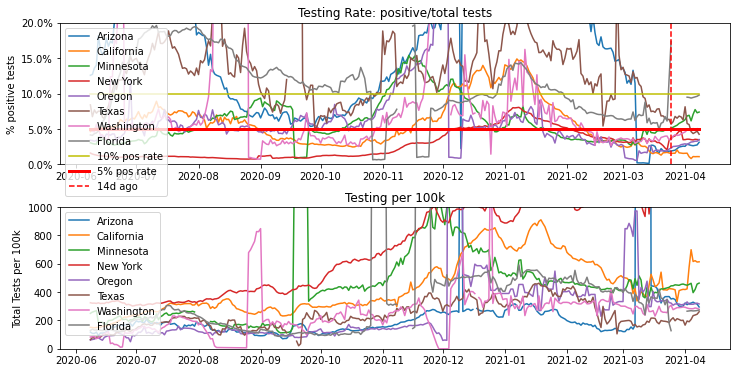

In [7]:
# Testing Rates
combine = combine['6/1/2020':]

for sub in [state_info]:
    td = combine.index[-1]
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    for i,r in sub.iterrows():
        new_cases_per_pop =  combine['Confirmed',r['State']].diff().rolling(7).mean()/(r['Pop']/1e5)
        new_tests_per_pop = combine['Testing_Rate',r['State']].diff().rolling(7).mean()
        new_tests_per_pop[new_tests_per_pop <0] = np.nan
        perc_test_pos = new_cases_per_pop/new_tests_per_pop
        plt.plot(combine.index, perc_test_pos, label=r['State'])
    plt.plot((pd.datetime(2020,6,8),td),(0.1,0.1), label='10% pos rate', c='y')
    plt.plot((pd.datetime(2020,6,8),td),(0.05,0.05), linewidth=3, label='5% pos rate', c='r')
    plt.plot([td - pd.Timedelta('14D')]*2,[0,0.2],'--',c='r',label='14d ago')
    plt.ylim(0,0.2)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.title("Testing Rate: positive/total tests")
    plt.ylabel("% positive tests")
    plt.legend(loc='upper left')
    # Testing Rates
    #plt.figure(figsize=(16,8))
    plt.subplot(2,1,2)
    for i,r in sub.iterrows():
        new_tests_per_pop = combine['Testing_Rate',r['State']].diff().rolling(7).mean()
        new_tests_per_pop[new_tests_per_pop <0] = np.nan
        plt.plot(combine.index, new_tests_per_pop, label=r['State'])
    plt.subplots_adjust(hspace=0.3)    # Need more space for the long legend on plot 1
    plt.ylim(0,1000)
    plt.title("Testing per 100k")
    plt.ylabel('Total Tests per 100k')
    plt.legend(loc='upper left')